# Analysis of results with `MiniGridEnv`

This notebook explores and visualize the results on `MiniGridEnv` adopting different strategies:
1. random action policy
2. market-only policy
3. battery-first policy
4. 20/80 policy
5. 50/50 policy
6. training a PPO agent with StableBaselines3 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


/Users/dave/miniconda3/envs/ernesto-gym/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm 
from datetime import datetime
import os
import orjson as json
from pathlib import Path
from collections import OrderedDict

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

plots_dir = 'examples/single_agent/plots'
os.makedirs(plots_dir, exist_ok=True)

In [3]:
alg_color = OrderedDict({
    'random': plot_colors[0],
    'only_market': plot_colors[1],
    'battery_first': plot_colors[2],
    '20-80': plot_colors[3],
    '50-50': plot_colors[4],
    'ppo': plot_colors[5],
    'a2c': plot_colors[6]
})

In [4]:
exp_name = "no_weights_norm_trad"
folder = "./logs/{}/results/".format(exp_name)

do_not_save = True

In [5]:
algs = [f for f in alg_color.keys() if f in os.listdir(folder)]

In [6]:
algs

['random', 'only_market', 'battery_first', '20-80', '50-50', 'ppo', 'a2c']

In [7]:
def load_results(alg:str):

    alg_res = []

    results_folder = folder + alg +'/'
    tests_files = [f for f in os.listdir(results_folder)]

    for file in tqdm(tests_files):
        f = open (results_folder + file, "r")
        data = json.loads(f.read())
        alg_res.append(data)

    return alg_res

In [8]:
res_dict = {}

for alg in algs:
    res_dict[alg] = load_results(alg)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


In [9]:
timestamps = pd.read_csv("ernestogym/ernesto/data/demand/dataset.csv", usecols=['timestamp'])['timestamp'].values.tolist()

In [10]:
timestamps = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in timestamps]

In [11]:
algs

['random', 'only_market', 'battery_first', '20-80', '50-50', 'ppo', 'a2c']

In [12]:
alg_names = {
    'a2c': 'A2C',
    'battery_first': 'Battery-first',
    '20-80': '20-80',
    'random': 'Random',
    'ppo': 'PPO',
    '50-50': '50-50',
    'only_market': 'Only-market',
    'ppo2': 'PPO'
    
}

In [13]:
def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    if not do_not_save:
        save_path = os.path.join(plots_dir, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

## PLOTS

In [14]:
# Average return across all the test experiments throw boxplots
def average_return():
    data = {}
    colors = []
    
    for alg in algs:
        data[alg_names[alg]] = [res_dict[alg][i]['total_reward'] for i in range(len(res_dict[alg]))]
        colors.append(alg_color[alg])

    fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
    sns.boxplot(data, gap=.1, palette=colors)
    
    print({key: np.mean(values) for key, values in data.items()})
    
    savefig(fig, filename='average_return_{}.pdf'.format(exp_name))
    savefig(fig, filename='average_return_{}.png'.format(exp_name))
    
    return data

{'Random': 105637.36142313314, 'Only-market': 124144.69623681041, 'Battery-first': 82964.06205740522, '20-80': 117127.35825053696, '50-50': 105183.96242343643, 'PPO': 124144.69623681041, 'A2C': 124144.69623681041}


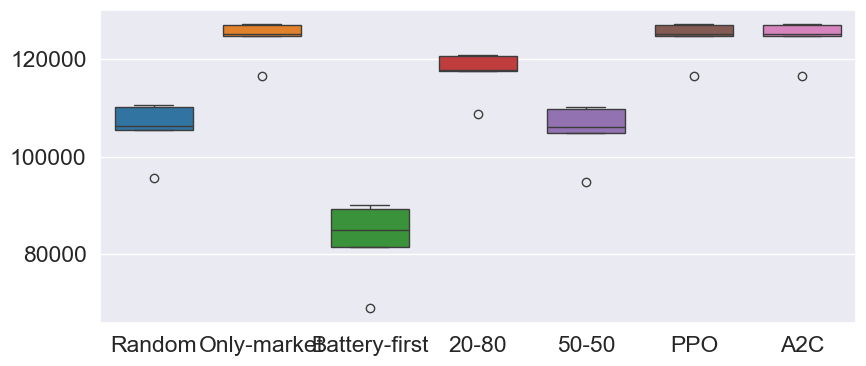

In [15]:
df = pd.DataFrame.from_dict(average_return())

In [16]:
df.describe()

,Random,Only-market,Battery-first,20-80,50-50,PPO,A2C
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,105637.361423,124144.696237,82964.062057,117127.358251,105183.962423,124144.696237,124144.696237
std,6033.857531,4325.357504,8601.574903,4943.789668,6210.786539,4325.357504,4325.357504
min,95613.640742,116637.350483,68875.312872,108713.803656,94867.401071,116637.350483,116637.350483
25%,105484.104442,124828.685039,81507.378848,117644.325465,104921.979193,124828.685039,124828.685039
50%,106380.830530,125139.601711,85060.081268,117779.245516,106083.812308,125139.601711,125139.601711
75%,110150.406743,126933.365264,89190.306211,120606.055535,109752.100421,126933.365264,126933.365264
max,110557.824658,127184.478687,90187.231089,120893.361080,110294.519124,127184.478687,127184.478687


In [27]:
def cum_average_reward_terms_comparison(sampling_rate=50, reward_type='weighted_reward'):
    data = {}
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)
    
    for i, alg in enumerate(algs):
        means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax1.set(xlabel='Time', ylabel='Avg. Trading Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax2.set(xlabel='Time', ylabel='Avg. Operational Cost', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax3.set(xlabel='Time', ylabel='Avg. Action Clipping', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='cum_average_trading_term{}_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='cum_average_trading_term{}_{}.png'.format(exp_name, reward_type))

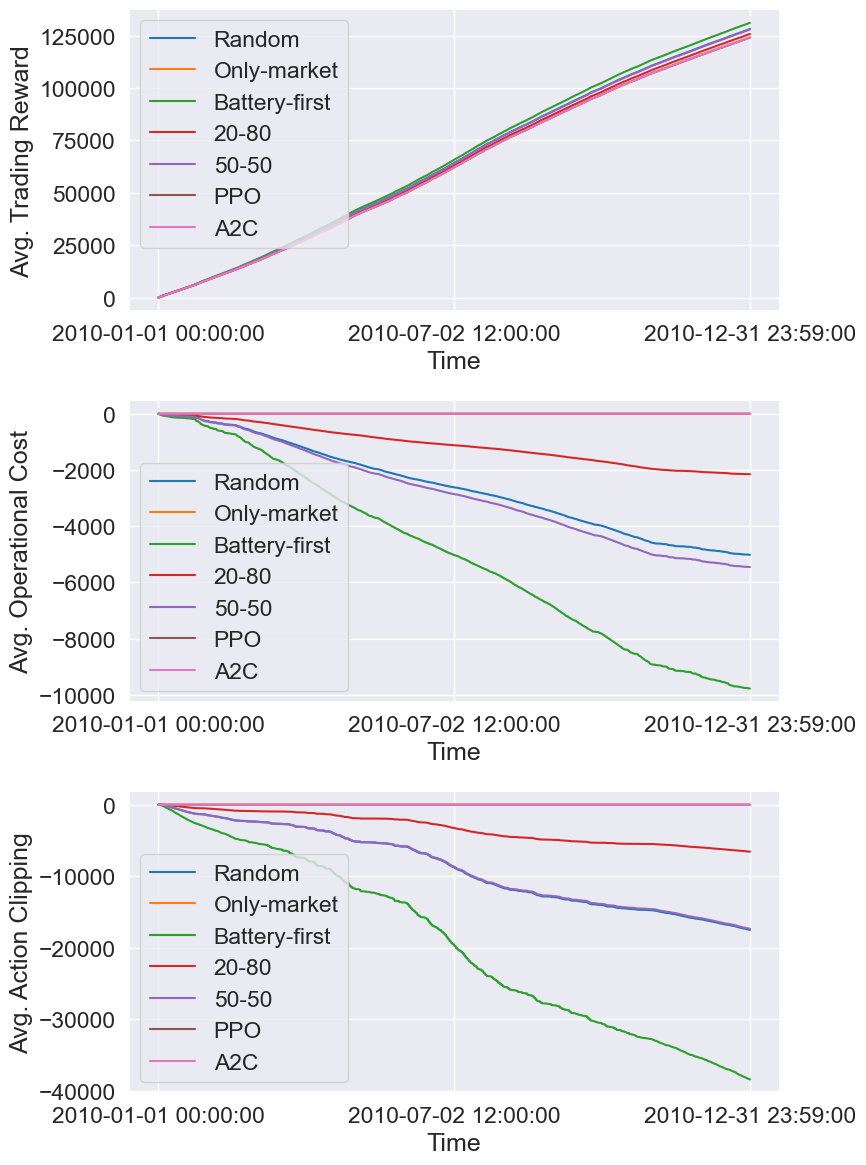

In [31]:
cum_average_reward_terms_comparison(reward_type='weighted_reward')

In [29]:
def average_total_reward_with_baseline(sampling_rate=50, reward_type='weighted_reward', baseline='20-80'):
    data = {}
    fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
    
    trad_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    op_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    clip_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    baseline_reward = np.cumsum(np.sum([trad_means, op_means, clip_means], axis=0))
    
    for i, alg in enumerate(algs):
        trad_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        op_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        clip_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)
        total_reward = np.cumsum(np.sum([trad_means, op_means, clip_means], axis=0))
        
        ax.plot(timestamps[::sampling_rate], (total_reward - baseline_reward)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax.set(xlabel='Time', ylabel="Delta cum. reward", xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax.legend()

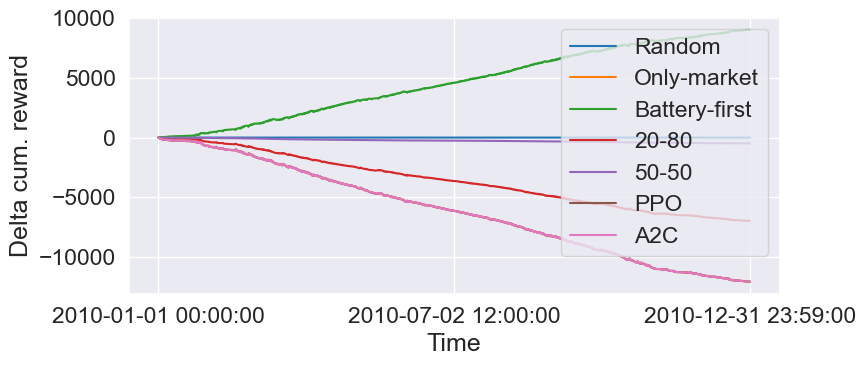

In [35]:
average_total_reward_with_baseline(reward_type='norm_reward', baseline='random')

In [21]:
def cum_average_reward_terms_with_baseline(sampling_rate=50, reward_type='weighted_reward', baseline='20-80'):
    data = {}
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)
    
    trad_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    op_means = np.mean([res_dict[baseline][i][reward_type]['r_op'] for i in range(len(res_dict[baseline]))], axis=0)     
    clip_means = np.mean([res_dict[baseline][i][reward_type]['r_clip'] for i in range(len(res_dict[baseline]))], axis=0)     
    
    for i, alg in enumerate(algs):
        means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means - trad_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax1.set(xlabel='Time', ylabel='Delta cum. R_trad', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means - op_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax2.set(xlabel='Time', ylabel='Delta cum. R_op', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means - clip_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
        ax3.set(xlabel='Time', ylabel='Delta cum. R_clip', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='cum_average_trading_term{}_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='cum_average_trading_term{}_{}.png'.format(exp_name, reward_type))

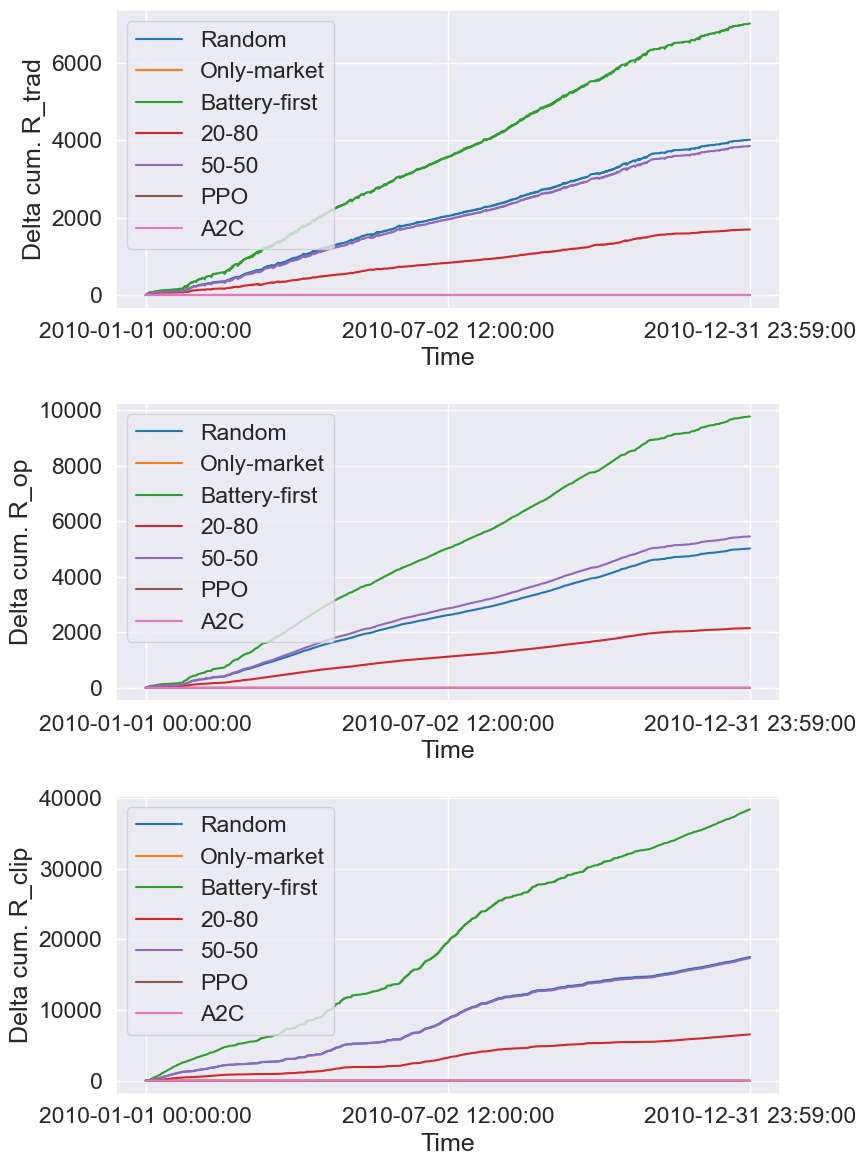

In [34]:
cum_average_reward_terms_with_baseline(reward_type='norm_reward', baseline='ppo')

In [32]:
def single_policy_reward_terms(alg, reward_type='weighted_reward', test='', sampling_rate=50):    
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)
    
    if not test:
        trad_list = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        op_list = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)     
        clip_list = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)     
    else:
        idx = [i for i in range(len(res_dict[alg])) if test == res_dict[alg][i]['test']][0]
        trad_list = res_dict[alg][idx][reward_type]['r_trad']   
        op_list = res_dict[alg][idx][reward_type]['r_op']     
        clip_list = res_dict[alg][idx][reward_type]['r_clip']     
    
    ax1.plot(timestamps[::sampling_rate], trad_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax1.set(xlabel='Time', ylabel='R_trad', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         

    ax2.plot(timestamps[::sampling_rate], op_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax2.set(xlabel='Time', ylabel='R_op', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    ax3.plot(timestamps[::sampling_rate], clip_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax3.set(xlabel='Time', ylabel='R_clip', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

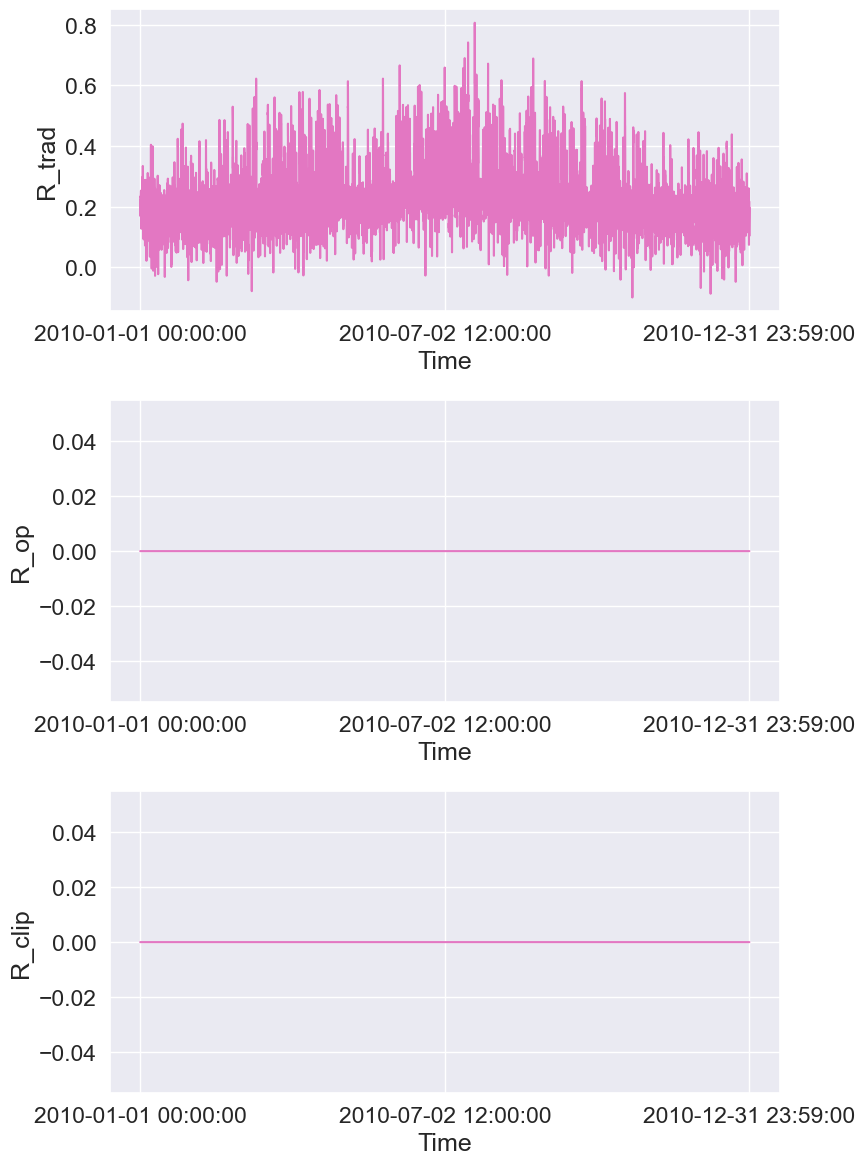

In [33]:
single_policy_reward_terms(alg='a2c', reward_type='weighted_reward', test='')

In [25]:
demand = pd.read_csv("ernestogym/ernesto/data/demand/dataset.csv")
generation = pd.read_csv("ernestogym/ernesto/data/generation/pv_dataset.csv")

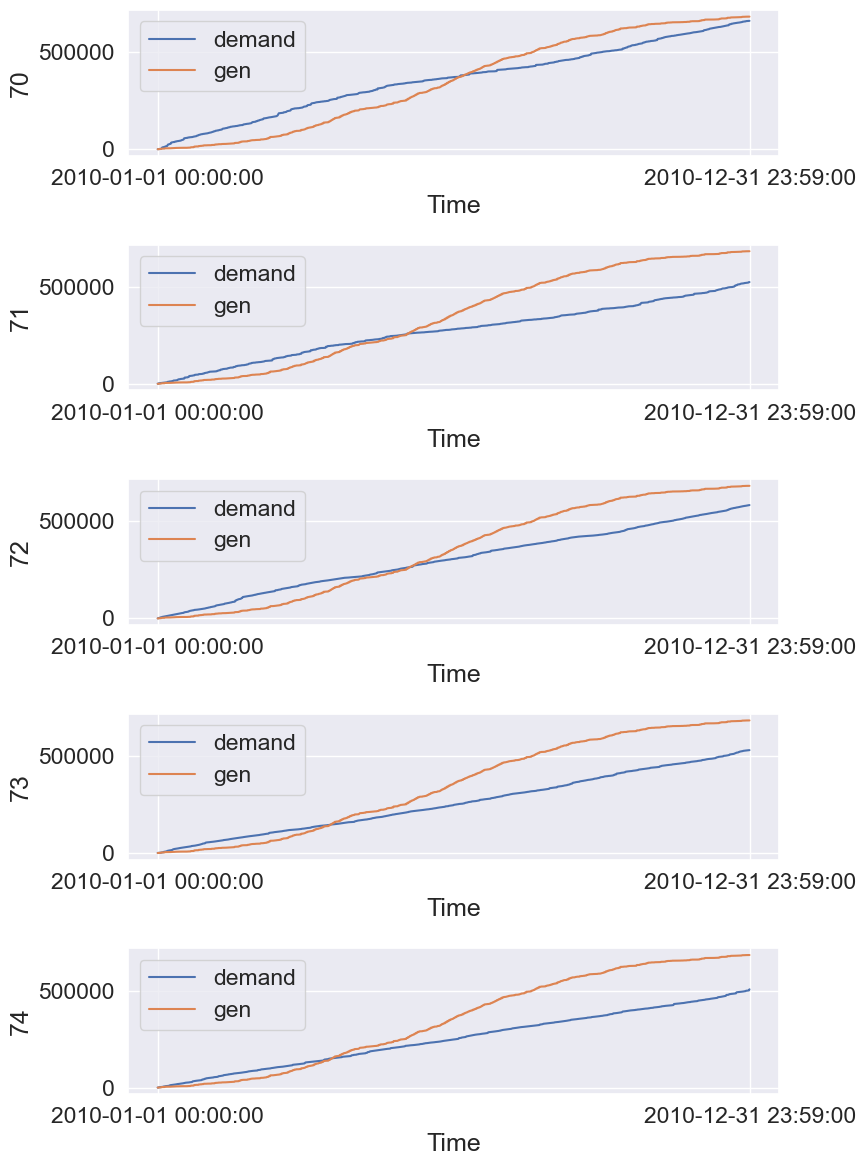

In [26]:
fig, axs = plt.subplots(5, 1, figsize=(9, 12), tight_layout=True)

sampling_rate = 500
timestamps = demand['timestamp'].values.tolist()

axs[0].plot(timestamps[::sampling_rate], np.cumsum(demand['70'][::sampling_rate]), label='demand')
axs[0].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[0].set(xlabel='Time', ylabel='70', xticks=[timestamps[0], timestamps[-1]])
axs[0].legend()

axs[1].plot(timestamps[::sampling_rate], np.cumsum(demand['71'][::sampling_rate]), label='demand')
axs[1].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[1].set(xlabel='Time', ylabel='71', xticks=[timestamps[0], timestamps[-1]])
axs[1].legend()

axs[2].plot(timestamps[::sampling_rate], np.cumsum(demand['72'][::sampling_rate]), label='demand')
axs[2].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[2].set(xlabel='Time', ylabel='72', xticks=[timestamps[0], timestamps[-1]])
axs[2].legend()

axs[3].plot(timestamps[::sampling_rate], np.cumsum(demand['73'][::sampling_rate]), label='demand')
axs[3].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[3].set(xlabel='Time', ylabel='73', xticks=[timestamps[0], timestamps[-1]])
axs[3].legend()

axs[4].plot(timestamps[::sampling_rate], np.cumsum(demand['74'][::sampling_rate]), label='demand')
axs[4].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[4].set(xlabel='Time', ylabel='74', xticks=[timestamps[0], timestamps[-1]])
axs[4].legend()

## Test Environments
We can imagine 3 different scenarios:
1. The energy price is raising and we prefere to use stored energy 
2. The replacement cost of batteries is increased and we prefer to limit its usage and rather trade with the market
3. We want to keep an average profile that and stay in the middle

For the above scenarios we can think to maximize a reward function with the following weigths:
1. r_trad * 0.9 + r_op * 0.1 -> in this way we penalize less for the battery usage
2. r_trad * 0.1 + r_op * 0.9 -> in this way we penalize less for the market usage
3. r_trad * 0.5 + r_op * 0.5 -> both market and usage have the same weight